In this notebook, i tried to predict the open price of Tesla Stock by simple RNN Model and LSTM model.<br>
Those who want to have detailed info on simple RNN and LSTM, may refer to great post below:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Loading Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
data = pd.read_csv("data/VOO_processed.csv")

In [4]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal,SMA_5,SMA_20,SMA_60,SMA_120
0,0,2010-09-09,102.500000,102.500000,101.139999,101.320000,78.490952,26500,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,2010-09-10,101.680000,101.860001,101.300003,101.779999,78.847305,8600,NaN,0.010320,0.005734,NaN,NaN,NaN,NaN
2,2,2010-09-13,102.959999,103.139999,102.500000,103.059998,79.838921,33750,NaN,0.052843,0.025041,NaN,NaN,NaN,NaN
3,3,2010-09-14,102.839996,103.480003,102.379997,103.040001,79.823387,59400,NaN,0.070166,0.040327,NaN,NaN,NaN,NaN
4,4,2010-09-15,102.620003,103.379997,102.400002,103.300003,80.024826,9250,NaN,0.088448,0.054642,102.5,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421 entries, 0 to 3420
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3421 non-null   int64  
 1   Date        3421 non-null   object 
 2   Open        3421 non-null   float64
 3   High        3421 non-null   float64
 4   Low         3421 non-null   float64
 5   Close       3421 non-null   float64
 6   Adj Close   3421 non-null   float64
 7   Volume      3421 non-null   int64  
 8   RSI         3408 non-null   float64
 9   MACD        3421 non-null   float64
 10  Signal      3421 non-null   float64
 11  SMA_5       3417 non-null   float64
 12  SMA_20      3402 non-null   float64
 13  SMA_60      3362 non-null   float64
 14  SMA_120     3302 non-null   float64
dtypes: float64(12), int64(2), object(1)
memory usage: 401.0+ KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [6]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 3421
Train data length : 2395
Validation data lenth : 1026


In [16]:
train_data = data[:length_train]#.iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal,SMA_5,SMA_20,SMA_60,SMA_120
0,0,2010-09-09,102.500000,102.500000,101.139999,101.320000,78.490952,26500,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,2010-09-10,101.680000,101.860001,101.300003,101.779999,78.847305,8600,NaN,0.010320,0.005734,NaN,NaN,NaN,NaN
2,2,2010-09-13,102.959999,103.139999,102.500000,103.059998,79.838921,33750,NaN,0.052843,0.025041,NaN,NaN,NaN,NaN
3,3,2010-09-14,102.839996,103.480003,102.379997,103.040001,79.823387,59400,NaN,0.070166,0.040327,NaN,NaN,NaN,NaN
4,4,2010-09-15,102.620003,103.379997,102.400002,103.300003,80.024826,9250,NaN,0.088448,0.054642,102.500000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,2390,2020-03-10,260.480011,263.809998,250.000000,263.809998,247.666550,10879100,30.292877,-9.583068,-6.154807,270.888004,290.192501,296.129500,287.583167
2391,2391,2020-03-11,256.660004,257.720001,247.619995,250.729996,235.386993,11480100,27.925577,-10.996655,-7.123176,263.538000,287.325002,295.452834,287.367667
2392,2392,2020-03-12,234.940002,243.679993,225.809998,226.479996,212.620895,24669300,25.138990,-13.913321,-8.481205,253.263998,283.146001,294.370167,286.950583
2393,2393,2020-03-13,240.660004,247.779999,228.100006,247.639999,232.486053,19533600,36.988728,-14.351924,-9.655349,248.153998,280.040001,293.605833,286.722167


In [17]:
validation_data = data[length_train:]#.iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal,SMA_5,SMA_20,SMA_60,SMA_120
2395,2395,2020-03-17,223.750000,233.949997,216.600006,232.880005,218.629272,15115500,38.870266,-17.475354,-12.370650,235.260001,271.627002,291.344334,285.915917
2396,2396,2020-03-18,216.080002,224.740005,208.309998,220.149994,206.678268,20177500,36.639562,-18.780888,-13.652698,229.144000,267.088501,290.100167,285.461917
2397,2397,2020-03-19,218.429993,226.000000,212.110001,220.339996,206.856598,12441200,32.462873,-19.574558,-14.837070,227.916000,262.620500,288.834167,285.024833
2398,2398,2020-03-20,222.800003,224.559998,210.050003,210.740005,197.844116,11533200,32.148715,-20.739118,-16.017479,220.536002,257.833001,287.427168,284.520500
2399,2399,2020-03-23,209.630005,210.779999,200.550003,204.270004,191.770020,14128200,26.617208,-21.931305,-17.200245,217.676001,253.234502,285.912334,283.951083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,3416,2024-04-08,477.149994,478.070007,475.970001,476.679993,476.679993,4736800,51.799979,2.971678,4.060090,475.787994,476.323001,462.401168,438.519501
3417,3417,2024-04-09,478.380005,478.600006,472.739990,477.269989,477.269989,5254200,45.310110,2.812669,3.810606,475.855994,476.686501,463.059167,439.158667
3418,3418,2024-04-10,471.910004,474.390015,470.670013,472.649994,472.649994,6933400,35.234176,2.287489,3.505982,474.913995,476.567500,463.636834,439.759251
3419,3419,2024-04-11,473.980011,477.429993,470.670013,476.059998,476.059998,5105200,44.918567,2.121978,3.229181,475.829993,476.655000,464.296168,440.432917


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [32]:
dataset_train = train_data['Open']
dataset_train.shape
# train_data.head()

(2395,)

In [34]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = dataset_train.to_numpy().reshape(-1,1)
dataset_train.shape

(2395, 1)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(2395, 1)

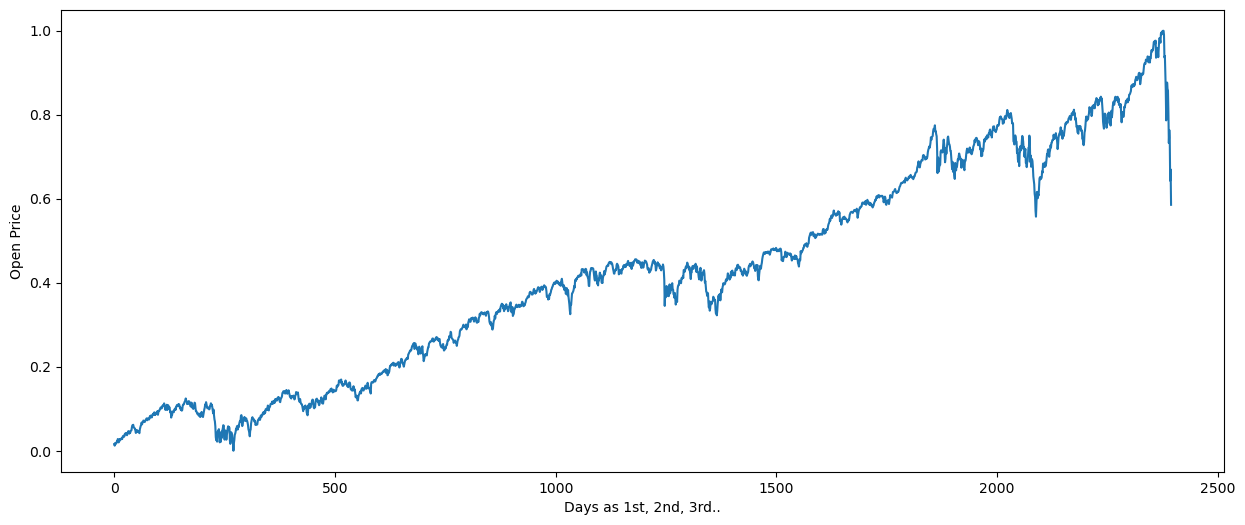

In [36]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

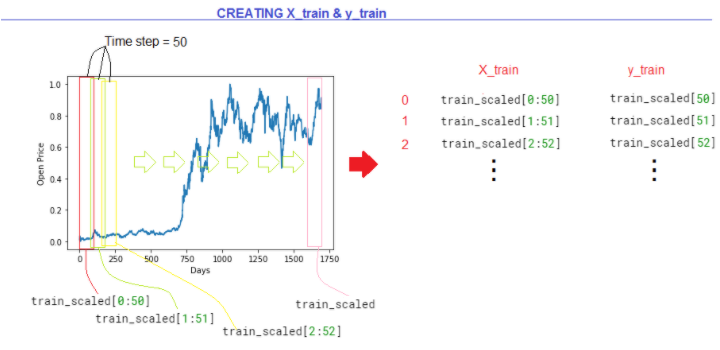

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [61]:
X_train = []
y_train = []

time_step = 5

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [62]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (2390, 5)
Shape of y_train before reshape : (2390,)


## Reshape

In [63]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (2390, 5, 1)
Shape of y_train after reshape : (2390, 1)


* Shape of X_train : 1134 x 50 x 1
* That means we have 1134 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [64]:
X_train[0]

array([[0.01590307],
       [0.01202196],
       [0.01808027],
       [0.01751229],
       [0.01647105]])

* Check the first item in y_train
* It is the price of 50th day

In [65]:
y_train[0]

array([0.01836424])

<a id="6"></a>
## 6.Creating RNN model 

In [82]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


# adding first RNN layer and dropout regulatization
regressor = Sequential([
    SimpleRNN(units=50, activation="tanh", return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    SimpleRNN(units=50, activation="tanh"),
    Dropout(0.2),
    Dense(units=1)
])

regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 108122.1719
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101547.8047
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98683.3125
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95594.2188
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94141.8594
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92211.6562
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 88193.6484
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85890.3750
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84424.4531
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82927.2734
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80921.1875
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80193.6719
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76860.8047
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75944.9844
Epoch 15/50
75/75 ━━━━━━━━━

<a id="7"></a>
## 7.Evaluating Model

In [67]:
# Losses
history.history["loss"]

[0.1457279622554779,
 0.0410340391099453,
 0.024400493130087852,
 0.018812021240592003,
 0.013025559484958649,
 0.009927116334438324,
 0.008189274929463863,
 0.00758084561675787,
 0.005929250735789537,
 0.006000575143843889,
 0.005313074216246605,
 0.004874568432569504,
 0.004406705033034086,
 0.004098343197256327,
 0.004187047481536865,
 0.003792006289586425,
 0.0034630654845386744,
 0.003165288595482707,
 0.0032215758692473173,
 0.003082872135564685,
 0.002850057790055871,
 0.0026707372162491083,
 0.002644650172442198,
 0.0026592642534524202,
 0.0025251402985304594,
 0.0023450441658496857,
 0.0024626373779028654,
 0.0023030361626297235,
 0.0022644081618636847,
 0.0022878549061715603,
 0.0022862341720610857,
 0.0019833699334412813,
 0.002201829105615616,
 0.0017929611494764686,
 0.001918453723192215,
 0.001820041798055172,
 0.001643808907829225,
 0.001736222766339779,
 0.0018348430749028921,
 0.0016783175524324179,
 0.0016380134038627148,
 0.0016848137602210045,
 0.0015855067176744342

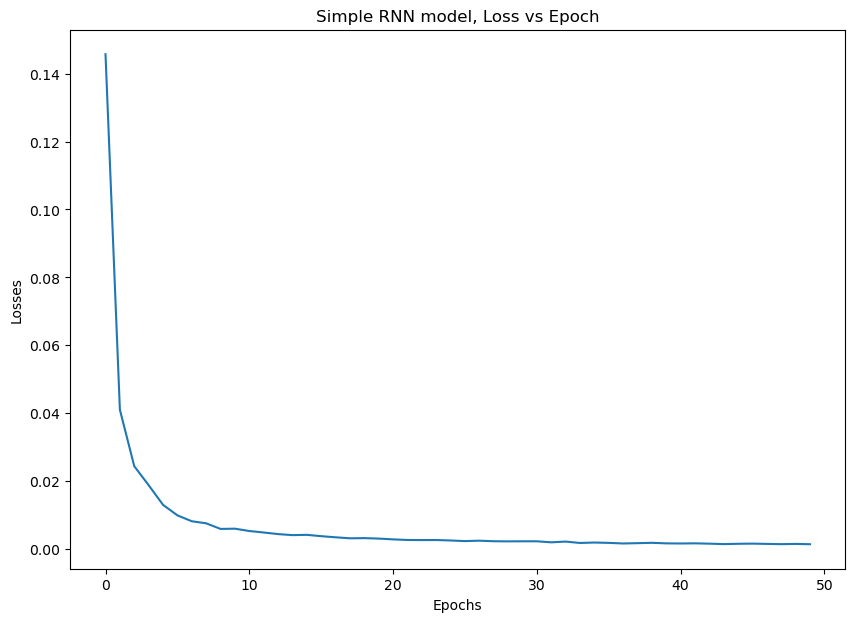

In [68]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

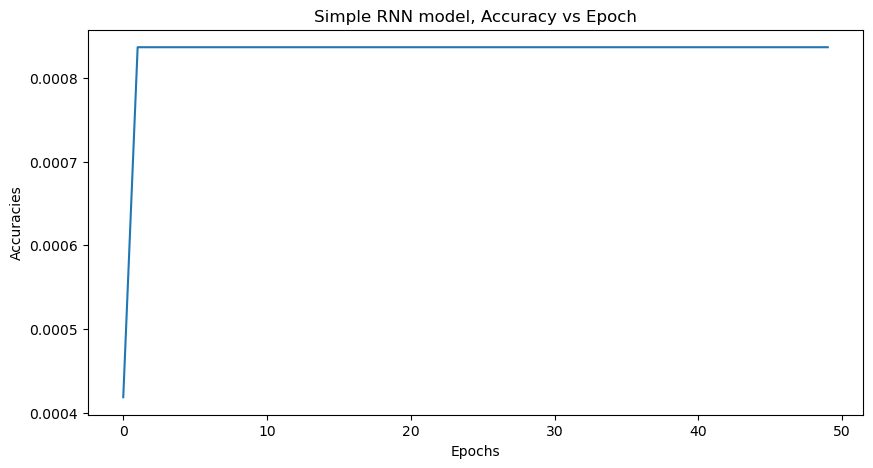

In [69]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data 

In [70]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


(2390, 1)

In [71]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2390, 1)

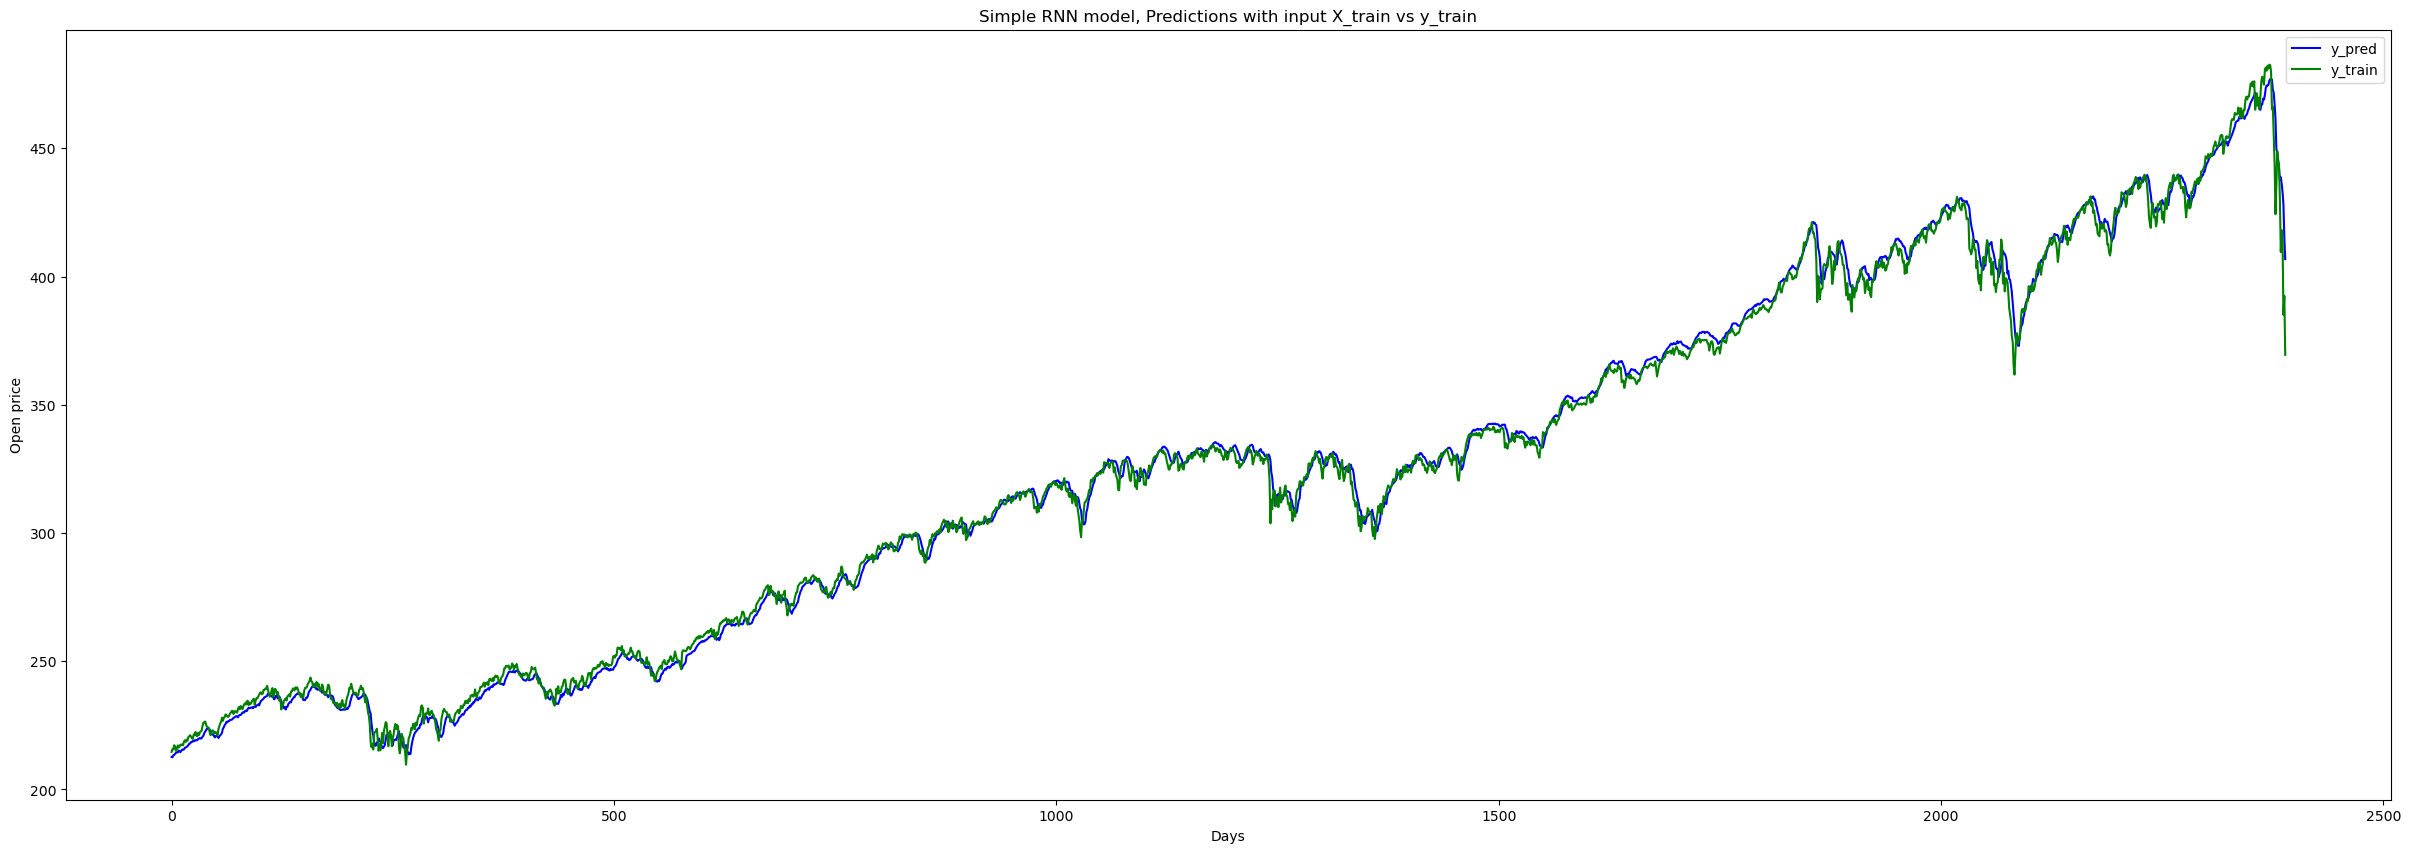

In [72]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data 

### Converting array and scaling

In [73]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (1026, 1)


### Creating X_test and y_test

In [74]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [75]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [76]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (1021, 5)
Shape of y_test before reshape : (1021,)


### Reshape

In [77]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [78]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (1021, 5, 1)
Shape of y_test after reshape : (1021, 1)


<a id="9"></a>
## 9.Evaluating with Validation Data 

In [79]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Shape of y_pred_of_test : (1021, 1)


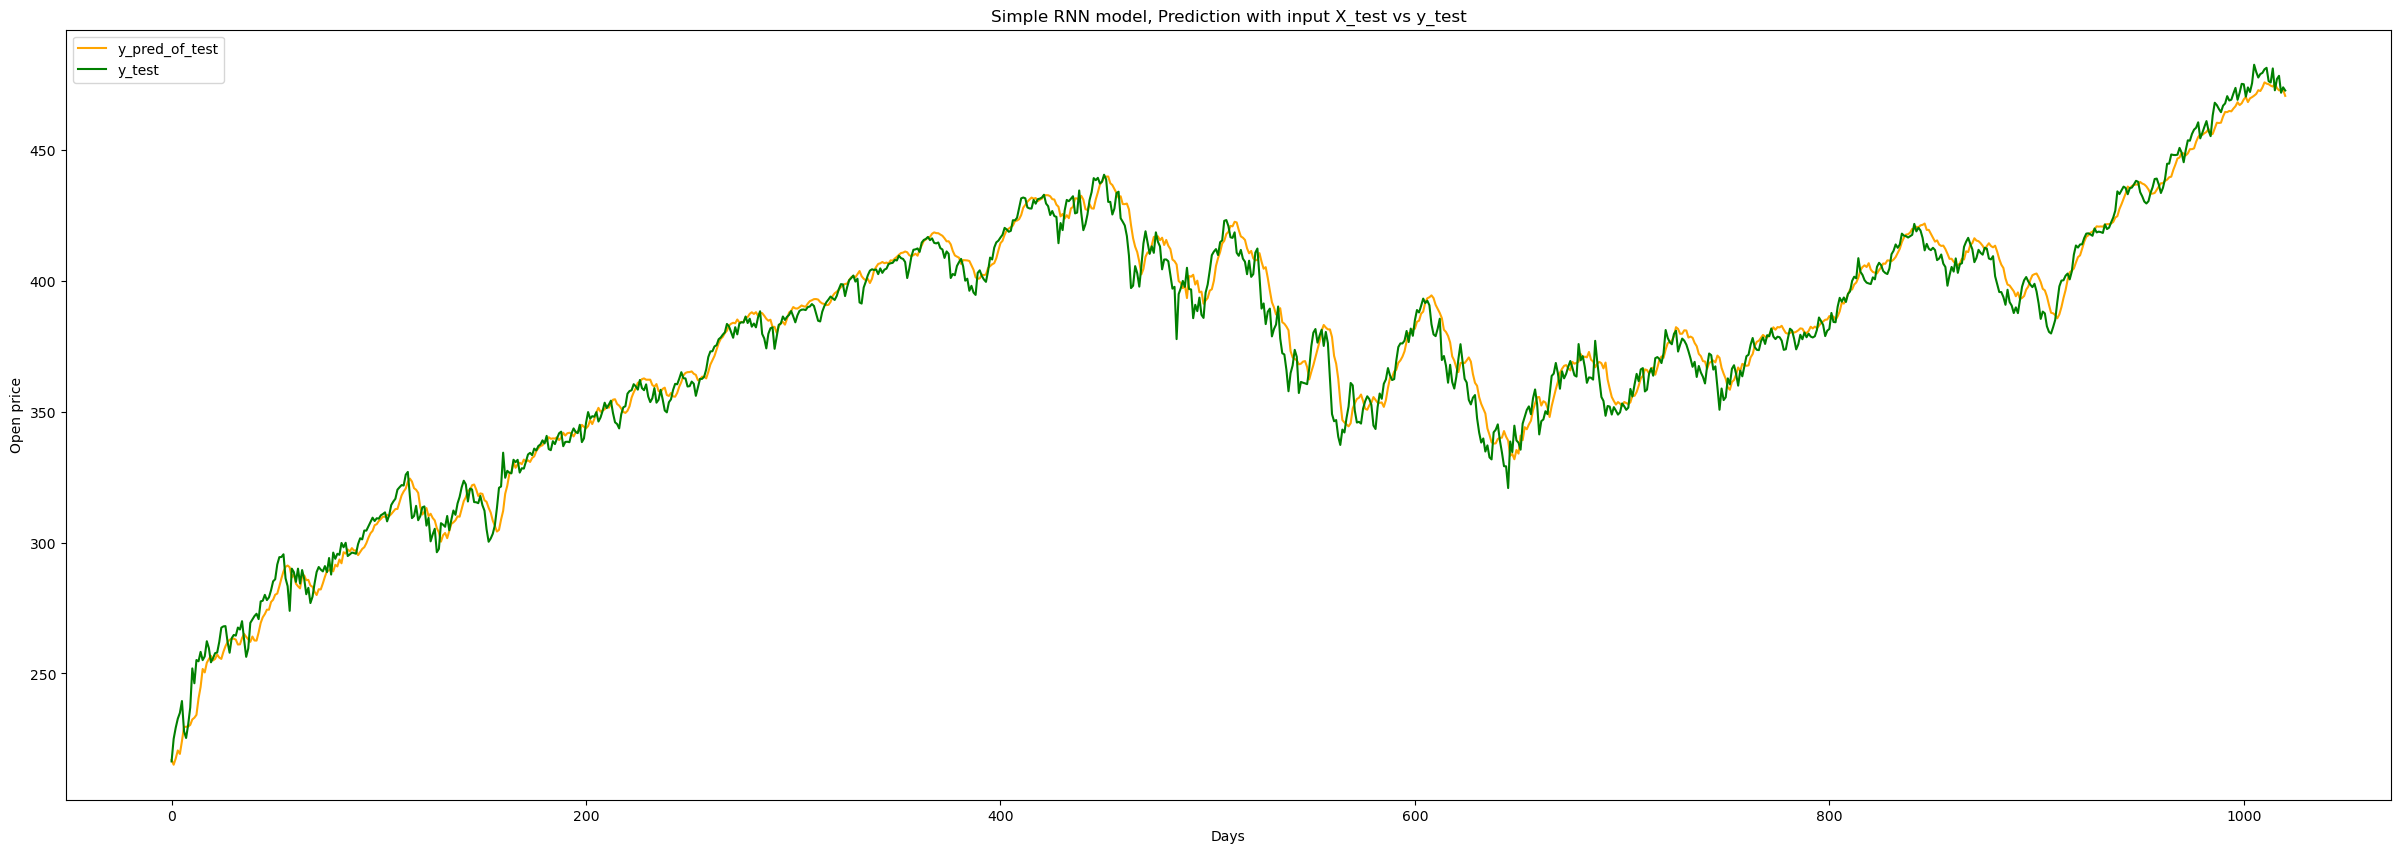

In [80]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

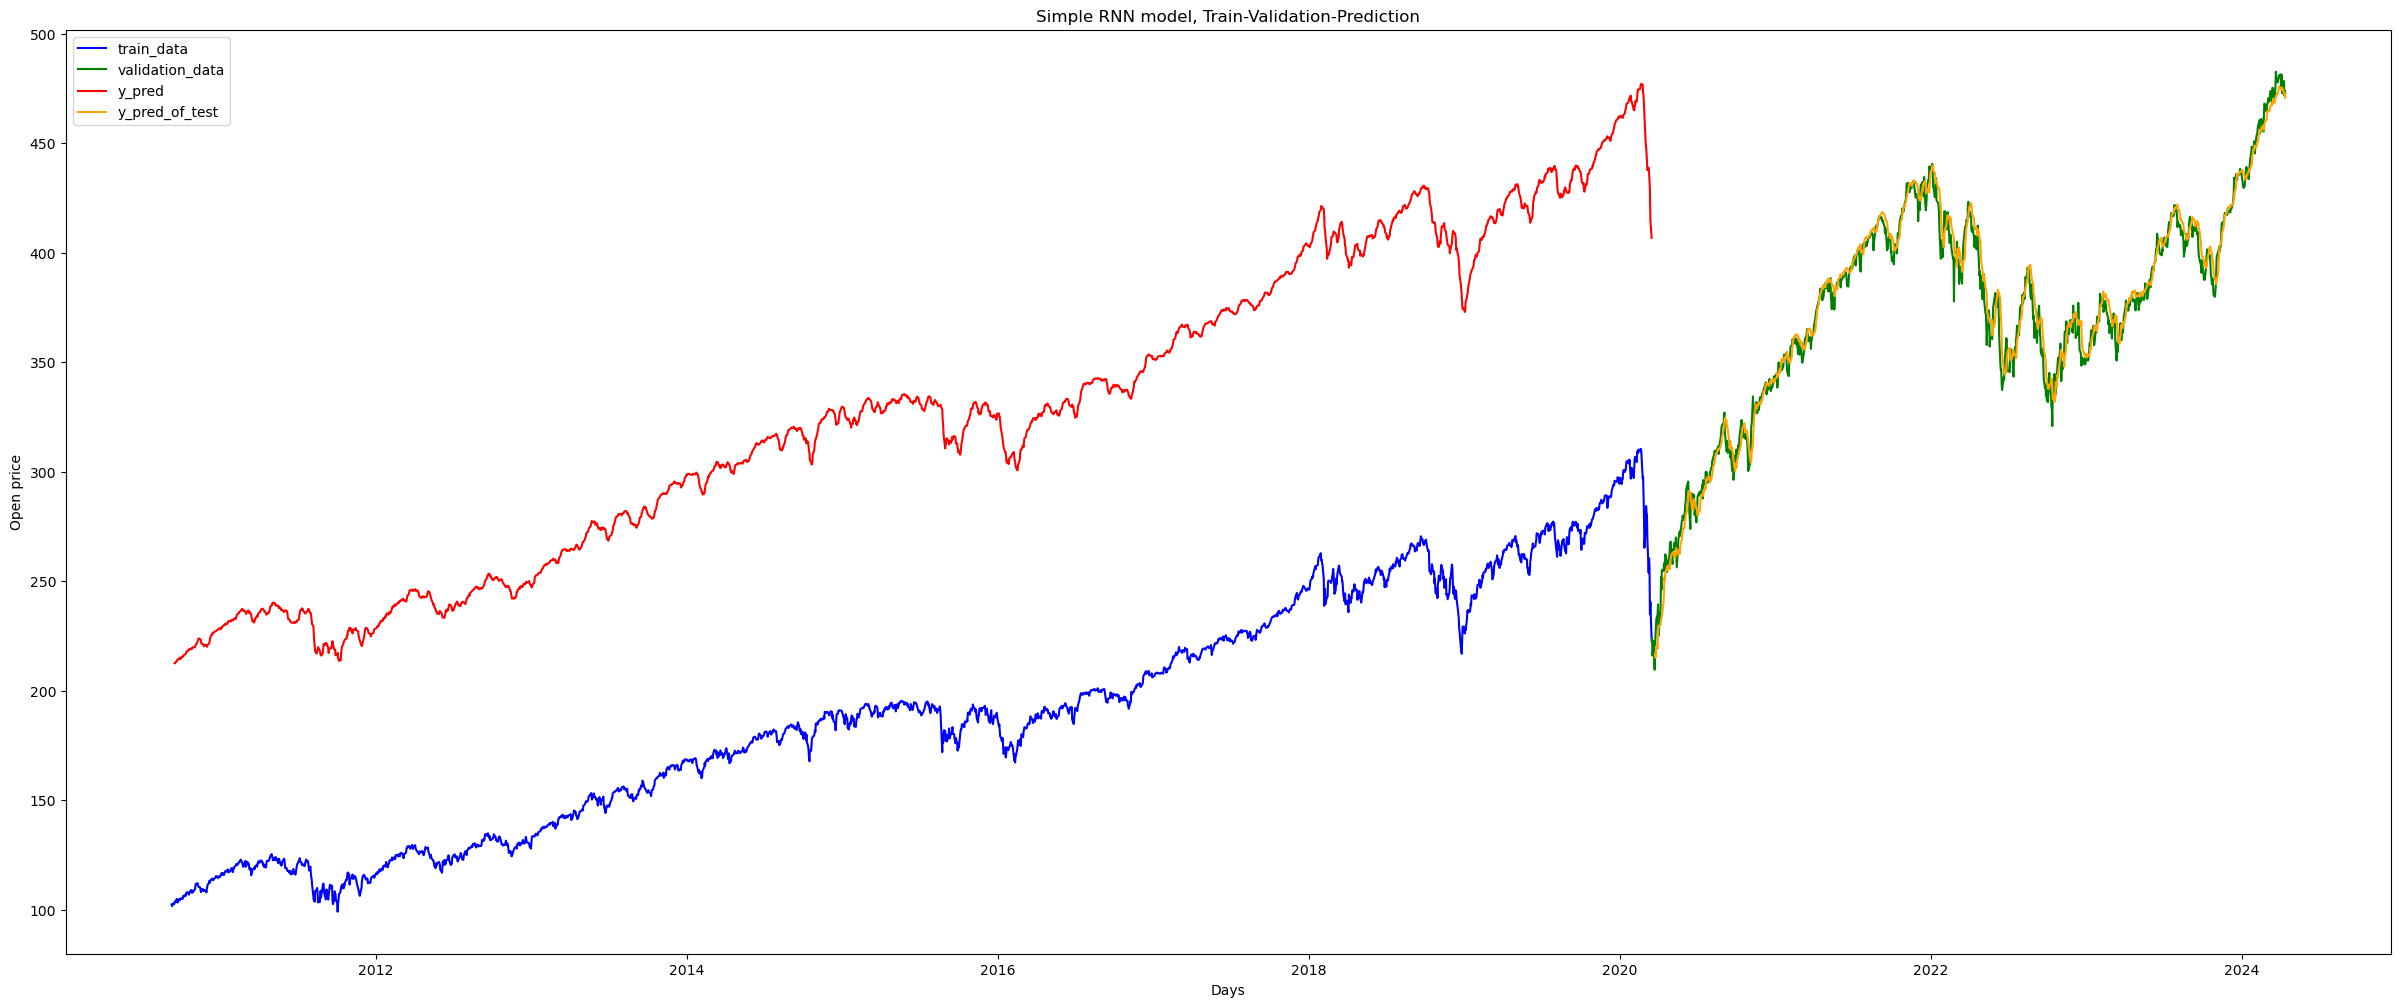

In [81]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creating LSTM Model

In [33]:
y_train = scaler.fit_transform(y_train)

In [34]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
114/114 [==============================] - 7s 62ms/step - loss: 0.0068 - accuracy: 0.0018
Epoch 2/10
114/114 [==============================] - 6s 56ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 3/10
114/114 [==============================] - 7s 57ms/step - loss: 0.0011 - accuracy: 0.0018
Epoch 4/10
114/114 [==============================] - 7s 58ms/step - loss: 9.3896e-04 - accuracy: 0.0018
Epoch 5/10
114/114 [==============================] - 7s 64ms/step - loss: 0.0010 - accuracy: 0.0018
Epoch 6/10
114/114 [==============================] - 6s 56ms/step - loss: 0.0010 - accuracy: 0.0018
Epoch 7/10
114/114 [==============================] - 6s 57ms/step - loss: 7.2914e-04 - accuracy: 0.0018
Epoch 8/10
114/114 [==============================] - 6s 56ms/step - loss: 8.1862e-04 - accuracy: 0.0018
Epoch 9/10
114/114 [==============================] - 6s 57ms/step - loss: 6.5757e-04 - accuracy: 0.0018
Epoch 10/10
114/114 [==============================] - 6s 56ms/step - loss:

<a id="11"></a>
## 11.Evaluating LSTM Model

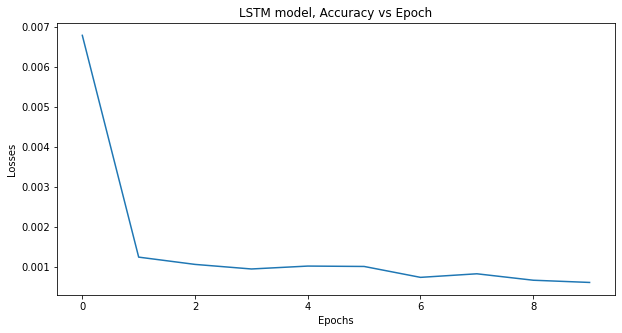

In [35]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

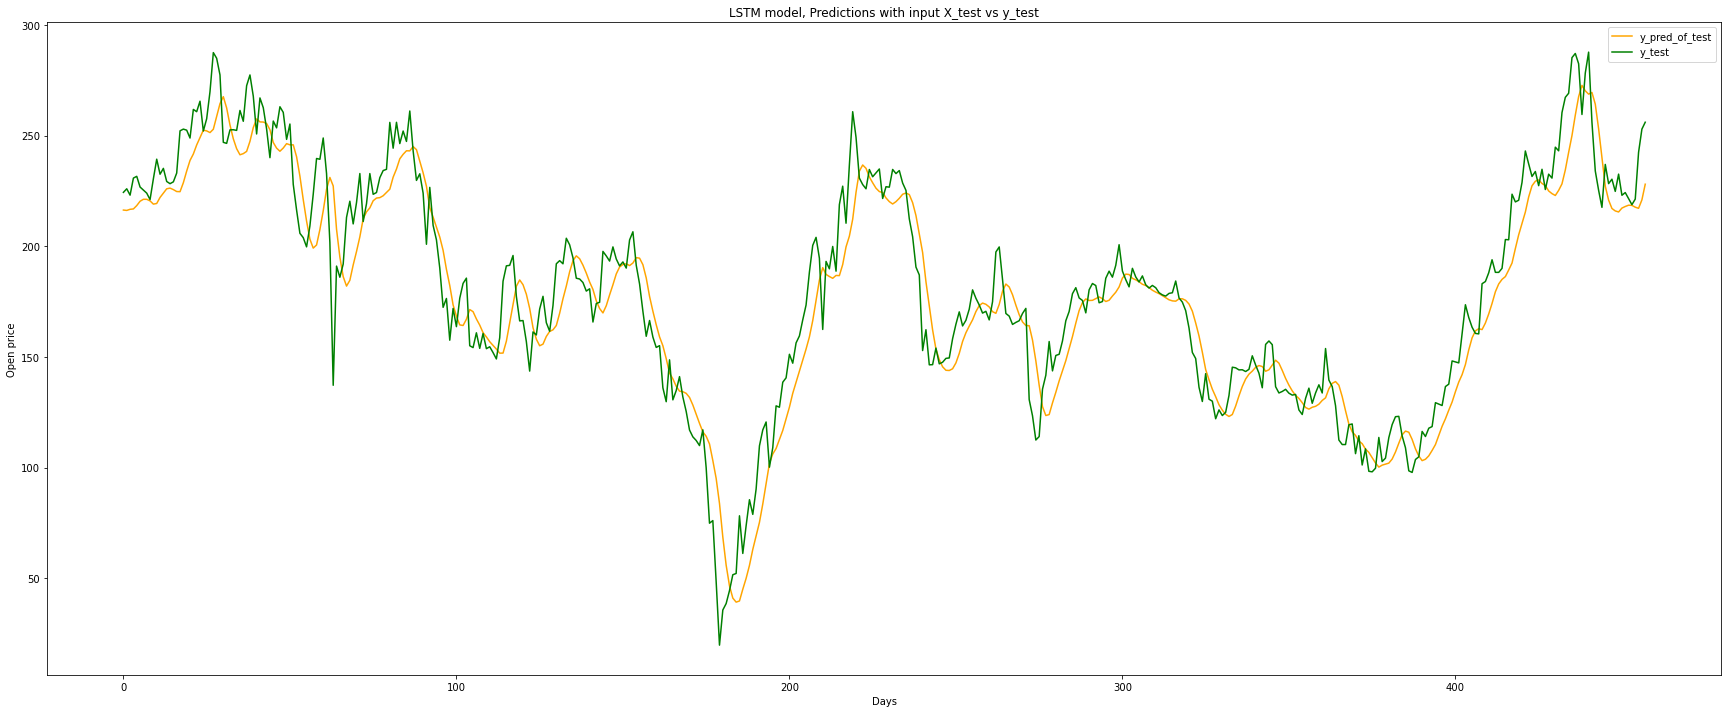

In [36]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

<a id="12"></a>
## 12.Future price prediction

* Which day is the last day in our data?

In [37]:
data.iloc[-1]

Date         3/17/2017
Open               264
High            265.33
Low              261.2
Close            261.5
Volume         6475900
Adj Close        261.5
Name: 1691, dtype: object

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [38]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.00946363],
        [0.04731867],
        [0.10354429],
        [0.04917441],
        [0.04898868],
        [0.06643166],
        [0.19075893],
        [0.18983106],
        [0.38652815],
        [0.35331247],
        [0.36054942],
        [0.43755803],
        [0.57320468],
        [0.5171645 ],
        [0.46316584],
        [0.48450549],
        [0.42345532],
        [0.49415485],
        [0.40675446],
        [0.47300067],
        [0.45611434],
        [0.58953431],
        [0.57394708],
        [0.7390982 ],
        [0.80478773],
        [0.82241588],
        [0.97624793],
        [0.99424758],
        [0.94971253],
        [0.73074763],
        [0.90981655],
        [1.        ],
        [0.69734648],
        [0.48691791],
        [0.40359993],
        [0.32974585],
        [0.51512331],
        [0.43217682],
        [0.45128979],
        [0.39877539],
        [0.47318612],
        [0.38188907],
        [0.39357964],
        [0.36722971],
        [0

In [39]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

Simple RNN, Open price prediction for 3/18/2017      : 250.00018
LSTM prediction, Open price prediction for 3/18/2017 : 255.20789


## Thanks for reading, please upvote:)